<a href="https://colab.research.google.com/github/ejnunn/GAN_Research/blob/main/notebooks/CycleGAN_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Utils

In [2]:
!rm -r GAN_Research
!git clone https://github.com/ejnunn/GAN_Research.git

rm: cannot remove 'GAN_Research': No such file or directory
Cloning into 'GAN_Research'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 206 (delta 118), reused 92 (delta 39), pack-reused 0
Receiving objects: 100% (206/206), 6.77 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Library Imports

In [4]:
import torch
from torch import nn
from tqdm.auto import tqdm # progress bars
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # visualizations
import pandas as pd # data processing
import shutil # file management
import torch.nn.functional as F # used in Hyperparameters cell
from skimage import color
import numpy as np

from GAN_Research.GAN_Research.GAN_Research.utils import *
from GAN_Research.models.cycleGAN_losses import *
from GAN_Research.scripts.datasets import ImageDataset
from GAN_Research.models.CycleGAN import CycleGAN

torch.manual_seed(0)

# Load data

## Load CelebA Dataset

In [5]:
## Create two groups of image files, smiling and not smiling ##

# Create dataframe to sort CelebA images
img_dir_celeba = '/content/drive/MyDrive/GAN Research/CycleGAN/CycleGAN Images/CelebA/'
attr_filename = 'list_attr_celeba.txt'

df = pd.read_csv(img_dir_celeba + attr_filename, skiprows=1, delim_whitespace=True)
df = df.reset_index()
df.rename(columns={'index': 'filename'}, inplace=True)

# Lists of smiling and non-smiling image filenames
smiling_list = list(df[['filename']].loc[df['Smiling'] == 1]['filename'])
not_smiling_list = list(df[['filename']].loc[df['Smiling'] == -1]['filename'])

In [6]:
## Unzip images and move files into the correct category ##

# Unzip images from drive and store in current directory
!unzip -q /content/drive/MyDrive/GAN\ Research/CycleGAN/CycleGAN\ Images/CelebA/img_align_celeba.zip

# Create training A and B subdirectories
!mkdir img_align_celeba/trainA
!mkdir img_align_celeba/trainB

# Move images into correct subdirectory
source_dir = 'img_align_celeba/'
destination_dir = 'img_align_celeba/trainA'
for img in smiling_list:
  shutil.move(source_dir + img, destination_dir)

source_dir = 'img_align_celeba/'
destination_dir = 'img_align_celeba/trainB'
for img in not_smiling_list:
  shutil.move(source_dir + img, destination_dir)
print('images loaded successfully!')

images loaded successfully!


In [7]:
## Load files into a Image Dataset object ##
load_shape = 128
target_shape = 128
# Apply transforms to dataset to augment
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

img_dir = 'img_align_celeba'
training_max_images = 2000
dataset = ImageDataset(img_dir, transform=transform, max_size=training_max_images)

print("Size of dataset: {} images".format(len(dataset)))

Size of dataset: 2000 images


# Training

In [8]:
# pretrained cycleGAN weights
weights_file = '/content/drive/MyDrive/GAN Research/CycleGAN/models/smile/smile_80_25_30_15.pth'
cyclegan = CycleGAN(weights_file=weights_file)

Epoch 0: Step 0: Generator (U-Net) loss: 0.0043881387710571285, Discriminator loss: 0.0012236934900283812


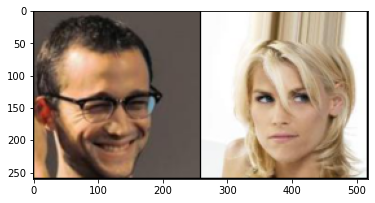

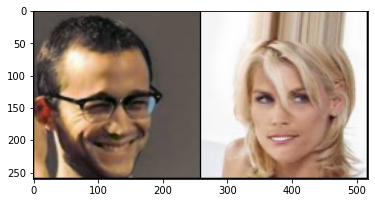

In [ ]:
cyclegan.train(dataset)

# FID Scoring

In [ ]:
# Calculate FID score for original trainA and trainB datasets
# Only for testing FID functionality
!python -m pytorch_fid --device cuda img_align_celeba/trainA img_align_celeba/trainB

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 53.3MB/s]
tcmalloc: large alloc 1600208896 bytes == 0x5594a2262000 @  0x7fbf97e5e1e7 0x7fbf9589e46e 0x7fbf958eec7b 0x7fbf958ef35f 0x7fbf95991103 0x559416843050 0x559416842de0 0x5594168b7244 0x5594168b1b0e 0x55941684477a 0x5594168b2a45 0x5594168b1b0e 0x55941684477a 0x5594168b2a45 0x5594168b1e0d 0x55941684477a 0x5594168b2a45 0x55941684469a 0x5594168b2a45 0x55941684469a 0x5594168b6e50 0x5594168b1b0e 0x5594168b1813 0x5594168afcc0 0x559416842ee9 0x559416842de0 0x5594168b6ac2 0x5594168b1b0e 0x55941684477a 0x5594168b2a45 0x5594168b1b0e
100% 1954/1954 [02:14<00:00, 14.55it/s]
tcmalloc: large alloc 1600208896 bytes == 0x559501876000 @  0x7fbf97e5e1e7 0x7fbf9589e46e 0x7fbf958eec7b 0x7fbf958eed97 0x7fbf958e84a5 0x7fbf95993823 0x5594168430e4 0x559416842de0 0x5594168b76f5 0x

0


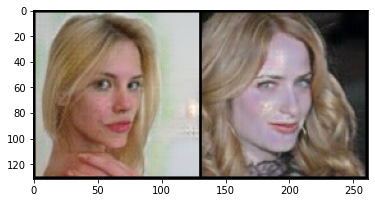

100


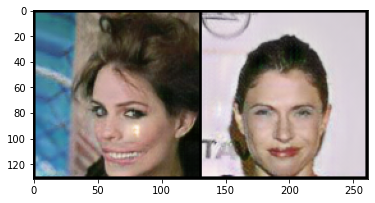

200


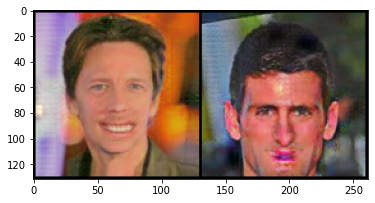

300


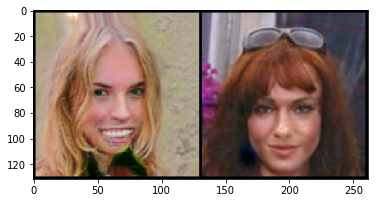

400


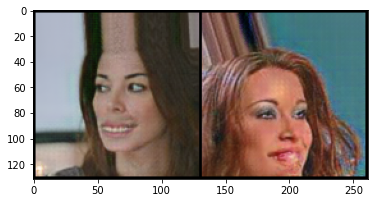

500


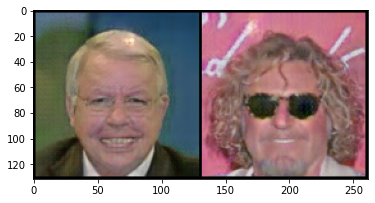

600


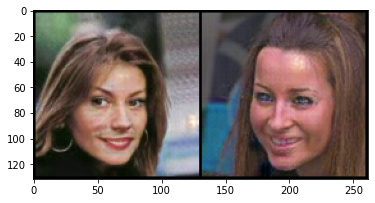

700


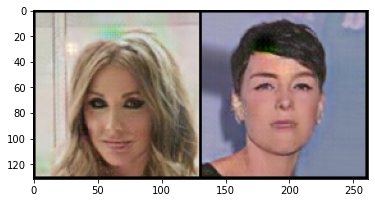

800


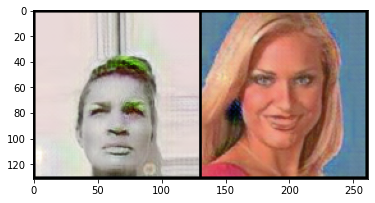

900


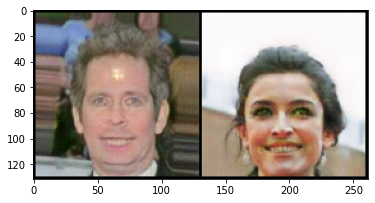

1000


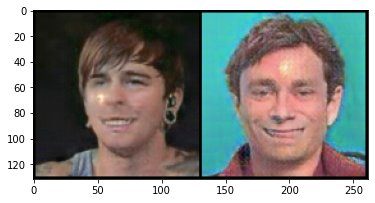

1100


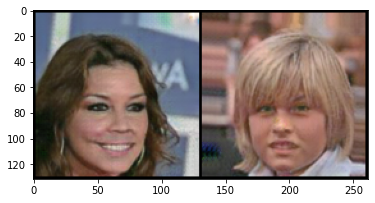

1200


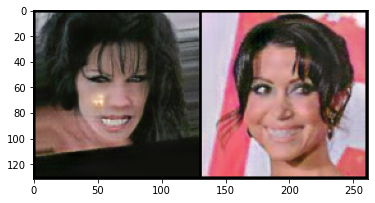

1300


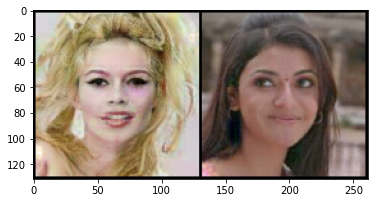

1400


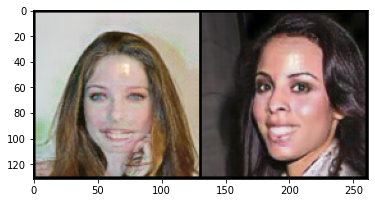

1500


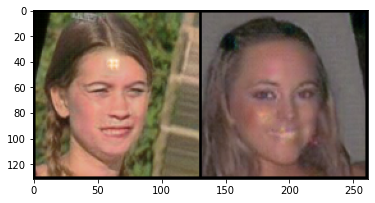

1600


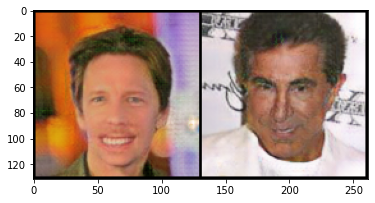

1700


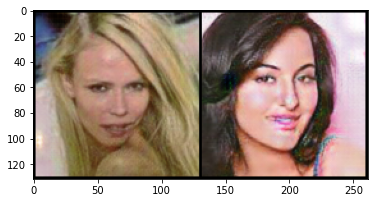

1800


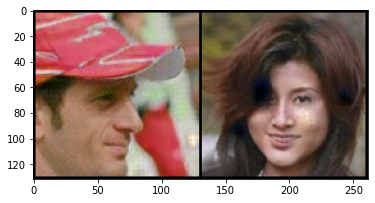

1900


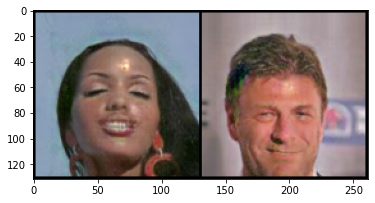

In [ ]:
from torchvision.utils import save_image

# Save 2k generated images from GAN
i = 0
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dir_real_A = 'real_A/'
dir_fake_A = 'fake_A/'
dir_real_B = 'real_B/'
dir_fake_B = 'fake_B/'

for real_A, real_B in tqdm(dataloader):
  real_A = real_A.to(device)
  real_B = real_B.to(device)
  fake_A = gen_BA(real_B)
  fake_B = gen_AB(real_A)

  if i % 100 == 0:
    print(i)
    show_tensor_images(torch.cat([fake_A, fake_B]), size=(dim_A, target_shape, target_shape))
  
  # save image
  save_image(real_A, '{}test_img{}.jpg'.format(dir_real_A, str(i)))
  save_image(fake_A, '{}test_img{}.jpg'.format(dir_fake_A, str(i)))

  save_image(real_B, '{}test_img{}.jpg'.format(dir_real_B, str(i)))
  save_image(fake_B, '{}test_img{}.jpg'.format(dir_fake_B, str(i)))

  i += 1

In [ ]:
!python -m pytorch_fid --device cuda real_A/ fake_A/

100% 40/40 [00:02<00:00, 14.43it/s]
100% 40/40 [00:02<00:00, 14.60it/s]
FID:  27.47809023070448


In [ ]:
!python -m pytorch_fid --device cuda real_B/ fake_B/

100% 40/40 [00:02<00:00, 14.59it/s]
100% 40/40 [00:02<00:00, 14.71it/s]
FID:  24.229858665779318


In [ ]:
x = torch.rand(1,64,64)

In [ ]:
x.flatten().shape

torch.Size([4096])